[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ychdo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


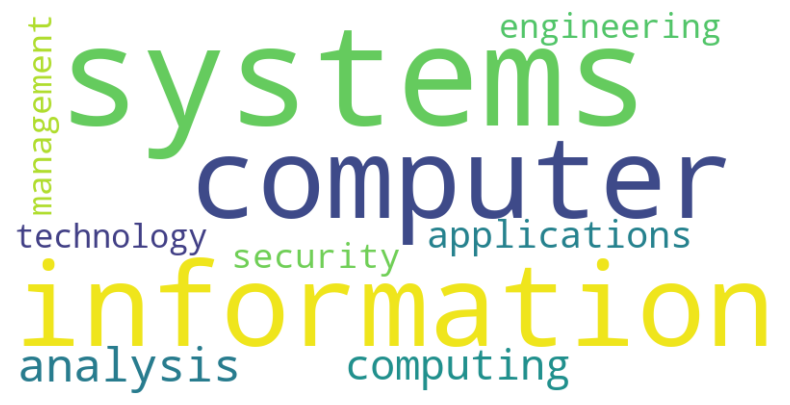

In [1]:
# 1. word cloud
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

# OpenLibrary API URL
BASE_URL = "https://openlibrary.org/search.json?q=data+science"
page_range = 1000

def fetch_books():
    books = []
    for page in range(1, page_range+1):
        response = requests.get(BASE_URL, params = {"page":page})
        json = response.json()
        temp = json.get("docs", [])
        books.extend(temp)
        if len(temp) < 100:
            break
    return books


def extract_words(books):
    words = []
    for book in books:
        title = book.get("title", "")
        subjects = book.get("subject", [])
        words.extend(title.split())
        for subject in subjects:
            words.extend(subject.split())
    return words


def clean_words(words):
    stop_words = set(stopwords.words("english"))
    cleaned_words = [word.lower().strip(string.punctuation) for word in words]
    cleaned_words = [word for word in cleaned_words if word not in stop_words and word.isalpha()]
    return cleaned_words




def generate_wordcloud(words):
    word_counts = Counter(words)
#   most_common_words = dict(word_counts.most_common(10))
#   wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(most_common_words)
    most_common_words = [word for word, _ in word_counts.most_common(12)]
    selected_words = most_common_words[2:12]  
    selected_word_counts = {word: word_counts[word] for word in selected_words}
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(selected_word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__":
    books = fetch_books()
    words = extract_words(books)
    cleaned_words = clean_words(words)
    generate_wordcloud(cleaned_words)

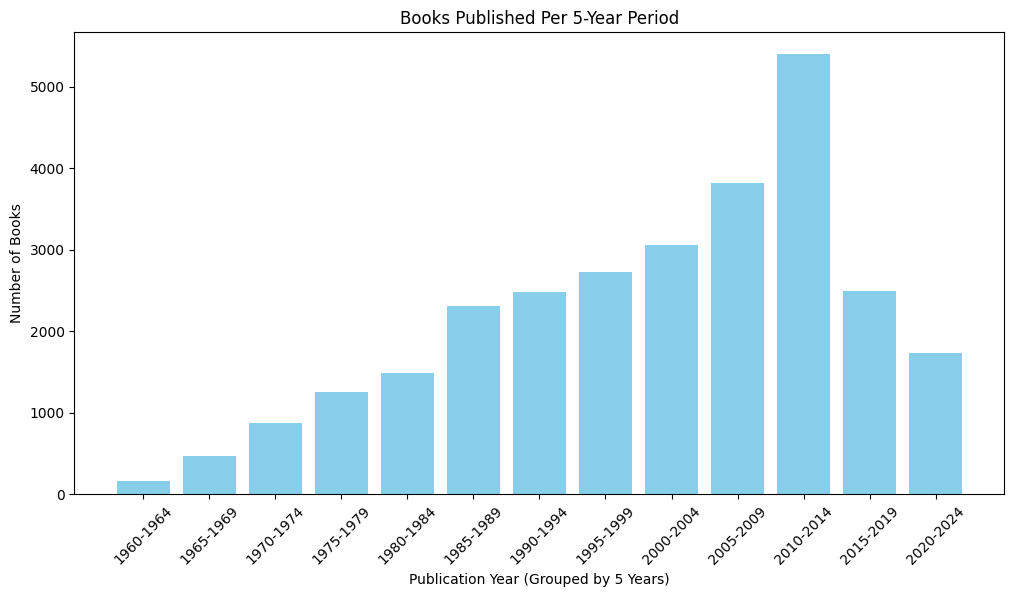

In [2]:
# 2. sort by time
from collections import defaultdict
def count_books_by_year(books):
    year_counts = defaultdict(int)
    for book in books:
        publish_year = book.get("first_publish_year")
        if isinstance(publish_year, int) and 1960 <= publish_year <= 2024: 
            year_counts[str(publish_year)] += 1
    return dict(year_counts)

def plot_year_distribution(year_distribution):
    grouped_years = defaultdict(int)
    
    for year, count in year_distribution.items():
            decade = (int(year) // 5) * 5 
            grouped_years[decade] += count
    
    grouped_years = {year: count for year, count in grouped_years.items() if count > 0}
    
    int_years = [year for year in grouped_years.keys() if isinstance(year, int)]
    str_years = [year for year in grouped_years.keys() if isinstance(year, str)]
    
    sorted_int_years = sorted(int_years)
    sorted_str_years = sorted(str_years, key=lambda x: int(x.split('-')[0]))  
    
    sorted_years = sorted_int_years + sorted_str_years
    
    counts = [grouped_years[year] for year in sorted_years]
    labels = [f"{year}-{year+4}" if isinstance(year, int) else year for year in sorted_years] 
    
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel("Publication Year (Grouped by 5 Years)")
    plt.ylabel("Number of Books")
    plt.title("Books Published Per 5-Year Period")
    plt.xticks(rotation=45)
    plt.show()


year_distribution = count_books_by_year(books)

plot_year_distribution(year_distribution)

In [8]:
# 3. plot by area
import pycountry
from IPython.display import display, Image

BASE_URL = "https://openlibrary.org/search.json?q=data+science"
def get_books_count_by_country(country):
    count = 0
    page = 1
    
    url = f"{BASE_URL}&place={country}"
    response = requests.get(url)
    data = response.json()
    
    count += data.get("numFound",0)
    return count

countries = [country.name for country in pycountry.countries]
book_counts = {}
for country in countries:
    count = get_books_count_by_country(country)
    if count != 0:
        book_counts[country] = count

print(book_counts)

{'Argentina': 3, 'American Samoa': 3, 'Antarctica': 16, 'Australia': 42, 'Austria': 4, 'Azerbaijan': 1, 'Burundi': 1, 'Belgium': 4, 'Bangladesh': 2, 'Bahamas': 1, 'Belarus': 1, 'Brazil': 9, 'Canada': 68, 'Switzerland': 3, 'Chile': 4, 'China': 21, 'Cameroon': 2, 'Congo': 1, 'Colombia': 3, 'Costa Rica': 1, 'Cuba': 2, 'Germany': 35, 'Denmark': 7, 'Ecuador': 2, 'Egypt': 4, 'Spain': 7, 'Estonia': 1, 'Finland': 8, 'France': 16, 'Georgia': 11, 'Ghana': 1, 'Guinea': 1, 'Greece': 1, 'Greenland': 1, 'Hong Kong': 2, 'Hungary': 1, 'Indonesia': 8, 'India': 38, 'British Indian Ocean Territory': 2, 'Ireland': 10, 'Israel': 8, 'Italy': 6, 'Jersey': 8, 'Japan': 39, 'Kazakhstan': 1, 'Kenya': 2, 'Cambodia': 1, 'Liberia': 1, 'Sri Lanka': 5, 'Lithuania': 1, 'Madagascar': 1, 'Mexico': 33, 'Mozambique': 1, 'Malawi': 2, 'Malaysia': 6, 'Namibia': 3, 'Netherlands': 13, 'Norway': 9, 'Nepal': 1, 'New Zealand': 9, 'Oman': 1, 'Pakistan': 3, 'Panama': 1, 'Peru': 1, 'Philippines': 3, 'Papua New Guinea': 1, 'Poland': 

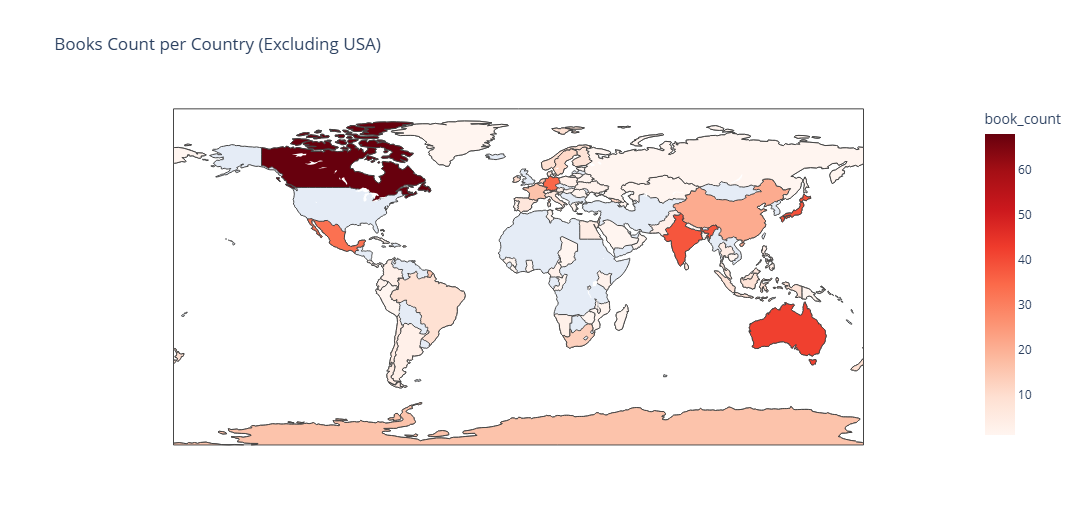

In [9]:
import plotly.express as px
import pandas as pd
import pycountry



def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

# excluding USA
book_counts1 = {k: v for k, v in book_counts.items() if k != "United States"}

book_counts_iso = {get_country_code(k): v for k, v in book_counts1.items() if get_country_code(k)}

df = pd.DataFrame(book_counts_iso.items(), columns=["iso_a3", "book_count"])

fig = px.choropleth(
    df,
    locations="iso_a3", 
    color="book_count",  
    hover_name="iso_a3", 
    color_continuous_scale="Reds",  
    title="Books Count per Country (Excluding USA)"
)

display(Image(filename="global.png"))

{'Alabama': 5, 'Alaska': 37, 'Arizona': 6, 'Arkansas': 5, 'California': 47, 'Colorado': 21, 'Connecticut': 2, 'Delaware': 3, 'Florida': 25, 'Georgia': 11, 'Hawaii': 10, 'Idaho': 18, 'Illinois': 8, 'Indiana': 6, 'Iowa': 4, 'Kansas': 8, 'Kentucky': 2, 'Louisiana': 3, 'Maine': 3, 'Maryland': 8, 'Massachusetts': 12, 'Michigan': 6, 'Minnesota': 7, 'Mississippi': 13, 'Missouri': 9, 'Montana': 28, 'Nebraska': 5, 'Nevada': 20, 'New Hampshire': 2, 'New Jersey': 8, 'New Mexico': 13, 'New York': 21, 'North Carolina': 14, 'North Dakota': 7, 'Ohio': 15, 'Oklahoma': 1, 'Oregon': 33, 'Pennsylvania': 7, 'Rhode Island': 2, 'South Carolina': 7, 'South Dakota': 3, 'Tennessee': 9, 'Texas': 17, 'Utah': 4, 'Vermont': 1, 'Virginia': 22, 'Washington': 24, 'West Virginia': 9, 'Wisconsin': 15, 'Wyoming': 3}


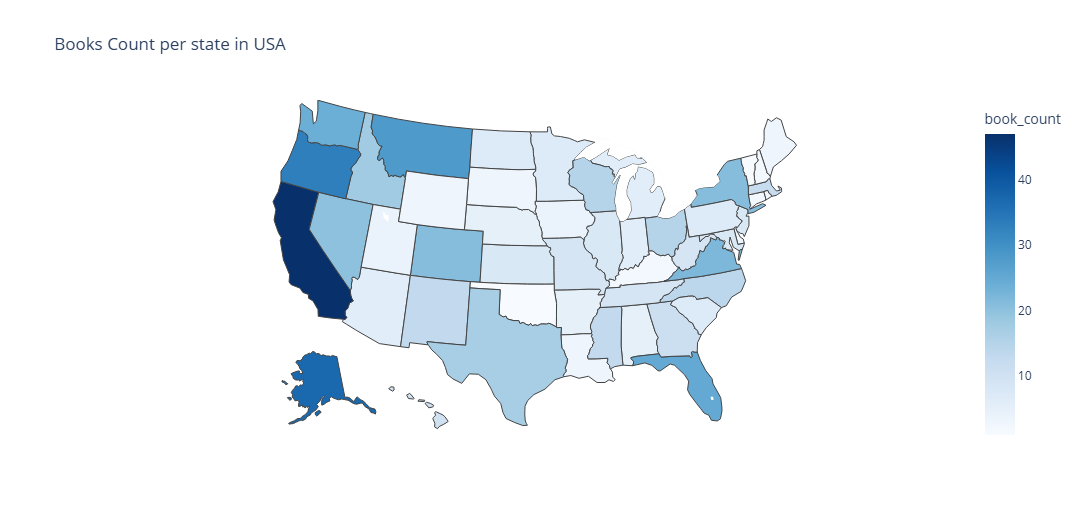

In [10]:
import us
BASE_URL = "https://openlibrary.org/search.json?q=data+science"
def get_books_count_by_state(state):
    count = 0
    page = 1
    
    url = f"{BASE_URL}&place={state}"
    response = requests.get(url)
    data = response.json()
    # print(data)
    count += data.get("numFound",0)
    return count

states = [state.name for state in us.states.STATES]
book_counts_st = {}
for state in states:
    count = get_books_count_by_state(state)
    if count != 0:
        book_counts_st[state] = count

print(book_counts_st)

state_abbr_map = {state.name: state.abbr for state in us.states.STATES}


data = pd.DataFrame({
    "state": [state_abbr_map[state] for state in book_counts_st.keys() if state in state_abbr_map],
    "book_count": list(book_counts_st.values())
})


fig = px.choropleth(
    data,
    locations="state",
    locationmode="USA-states",
    color="book_count",
    color_continuous_scale="Blues",
    scope="usa",
    title="Books Count per state in USA"
)

display(Image(filename="USA.png"))

{'United States': 1021, 'Canada': 68, 'Australia': 42, 'Japan': 39, 'India': 38}


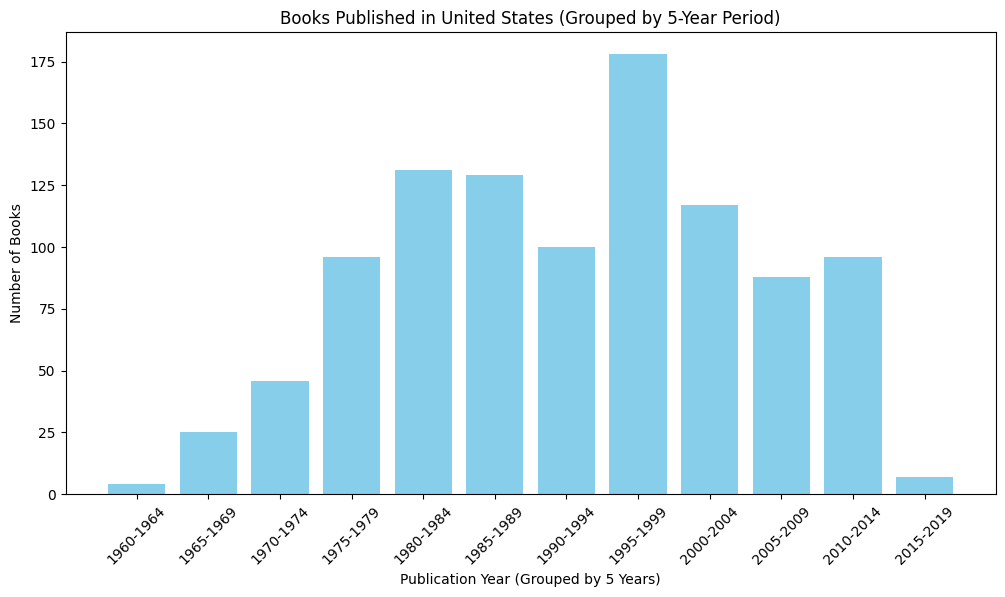

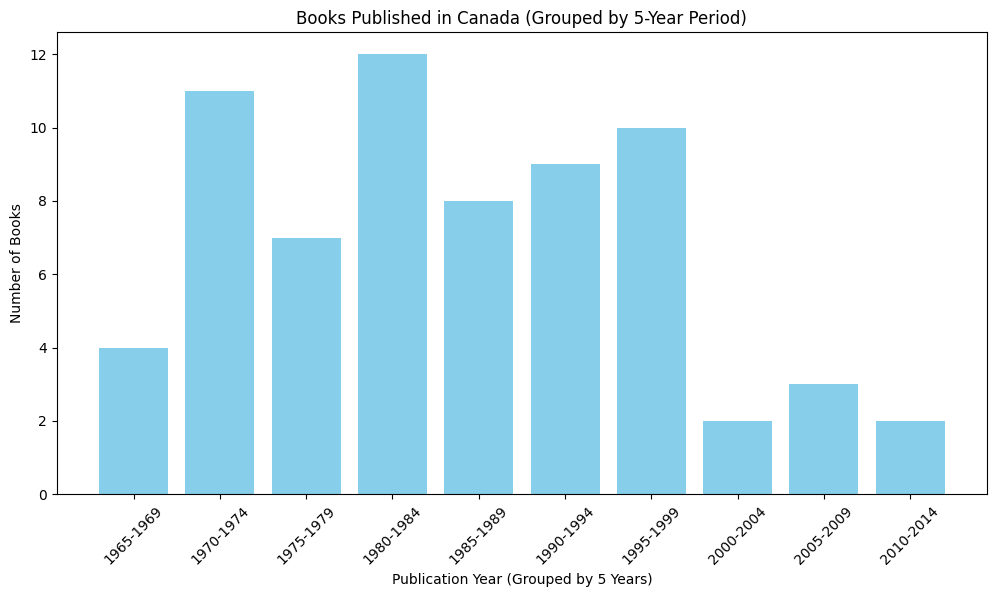

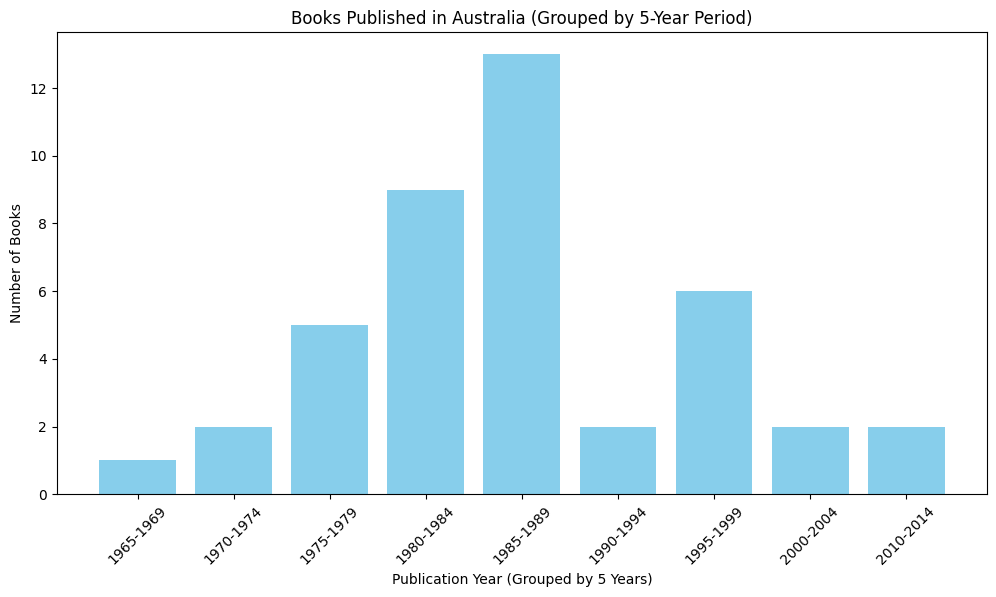

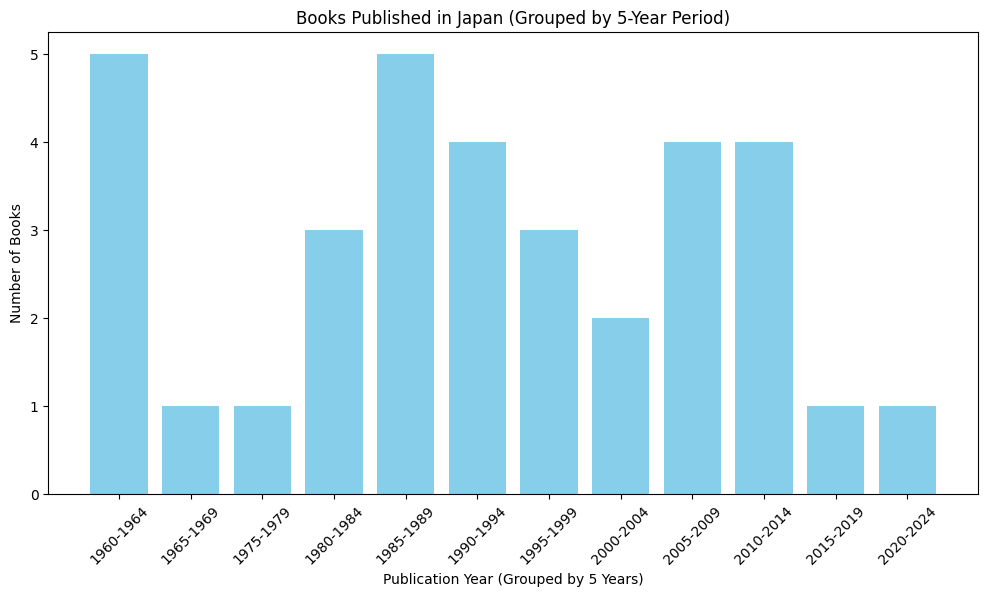

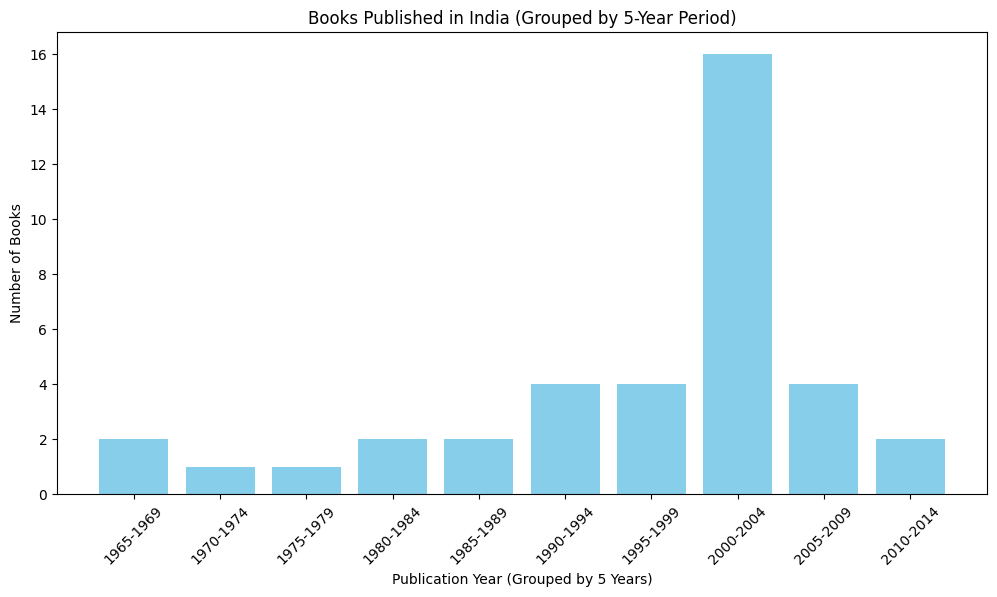

In [6]:
# 4. top five countries plot by time
from collections import defaultdict
import matplotlib.pyplot as plt

BASE_URL = "https://openlibrary.org/search.json?q=data+science"

def get_books_by_country(country):
    books = []
    url = f"{BASE_URL}&place={country}"
    for page in range(1, page_range+1):
        response = requests.get(url, params = {"page":page})
        json = response.json()
        temp = json.get("docs",[])
        books.extend(temp)
        if len(temp) < 100:
            break
    return books


def count_books_by_country_and_year(books, country_name):
    country_year_counts = defaultdict(int)
    
    for book in books:
        publish_year = book.get("first_publish_year")
        
        if isinstance(publish_year, int) and 1960 <= publish_year <= 2024 :
            country_year_counts[str(publish_year)] += 1
            
    return dict(country_year_counts)

def plot_country_year_distribution(country_name, year_distribution):
    grouped_years = defaultdict(int)
    
    for year, count in year_distribution.items():
        decade = (int(year) // 5) * 5
        grouped_years[decade] += count
    
    grouped_years = {year: count for year, count in grouped_years.items() if count > 0}
    
    int_years = [year for year in grouped_years.keys() if isinstance(year, int)]
    str_years = [year for year in grouped_years.keys() if isinstance(year, str)]
    
    sorted_int_years = sorted(int_years)
    sorted_str_years = sorted(str_years, key=lambda x: int(x.split('-')[0]))  
    
    sorted_years = sorted_int_years + sorted_str_years
    
    counts = [grouped_years[year] for year in sorted_years]
    labels = [f"{year}-{year+4}" if isinstance(year, int) else year for year in sorted_years] 
    
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel("Publication Year (Grouped by 5 Years)")
    plt.ylabel("Number of Books")
    plt.title(f"Books Published in {country_name} (Grouped by 5-Year Period)")
    plt.xticks(rotation=45)
    plt.show()

top_five = dict(sorted(book_counts.items(), key=lambda item: item[1], reverse=True)[:5])
print(top_five)

for country in top_five.keys():
    books = get_books_by_country(country)
    year_distribution = count_books_by_country_and_year(books, country)
    plot_country_year_distribution(country, year_distribution)